In [1]:
import numpy as np
import matplotlib.pyplot as plt

def g2_model(t, t0, T1, T2, Omega):
    """Analytic g^(2)(t) model from Phys. Rev. A 94, 063839 (2016)."""
    t = np.asarray(t)
    invT1, invT2 = 1/T1, 1/T2
    p = invT1 + invT2
    q = np.sqrt((invT1 - invT2)**2 - 4 * Omega**2 + 0j)
    dt = np.abs(t - t0)
    out = 1 - (p + q)/(2*q)*np.exp(-0.5*(p - q)*dt) + (p - q)/(2*q)*np.exp(-0.5*(p + q)*dt)
    return np.real(out)

# Load and normalize your data
#FNAME = "Bidirectional_histogram_2025-09-29_180310_480nW_mol2_6K.txt"
FNAME = "Bidirectional_histogram_2025-09-29_180310_480nW_mol2_6K.txt"
try:
    data = np.loadtxt(FNAME, skiprows=1)
except Exception:
    lines = []
    with open(FNAME) as f:
        for line in f:
            try:
                float(line.split()[0])
                lines.append(line)
            except Exception:
                continue
    data = np.loadtxt(lines)

t = data[:, 0]
counts = data[:, 1]
tail_fraction = 0.1
idx = np.argsort(np.abs(t))
n_tail = max(1, int(len(t) * tail_fraction))
baseline = np.mean(counts[idx[-n_tail:]])
g2 = counts / baseline

# --- Manual guesses ---
t0_guess = -51800.0
T1_guess = 5000.0
T2_guess = 1000.0
Omega_guess = 0.0001

In [2]:
from scipy.optimize import least_squares

# --- Prepare window around your guess ---
window_center = t0_guess
window_half_width = 20000.0  # adjust as needed
mask = (t >= window_center - window_half_width) & (t <= window_center + window_half_width)
t_win = t[mask]
g2_win = g2[mask]
counts_win = counts[mask]
sigma = np.sqrt(np.clip(counts_win, 1.0, None)) / baseline

print(f"Fit window: from {t_win.min():.1f} to {t_win.max():.1f} (width = {2*window_half_width:.0f})")

# --- Define residuals for least_squares ---
def residuals(params):
    t0, T1, T2, Omega = params
    model = g2_model(t_win, t0, T1, T2, Omega)
    return (model - g2_win) / sigma

# --- Run robust fit ---
initial = [t0_guess, T1_guess, T2_guess, Omega_guess]
lower = [t.min(), 1e-9, 1e-9, 0.0]
upper = [t.max(), np.inf, np.inf, np.inf]

lsq = least_squares(residuals, initial, bounds=(lower, upper),
                    loss="soft_l1", verbose=2, max_nfev=200000)
popt = lsq.x

# --- Print results ---
print("\nFitted parameters:")
for name, val in zip(["t0", "T1", "T2", "Omega"], popt):
    print(f"  {name:6s} = {val:.6g}")

# Save results for the next cell
fit_result = {
    "popt": popt,
    "window_center": window_center,
    "window_half_width": window_half_width,
    "t_win": t_win,
    "g2_win": g2_win,
    "sigma": sigma,
}

Fit window: from -71800.0 to -31800.0 (width = 40000)
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.7808e+01                                    2.49e+04    
       1              2         8.0819e+00      1.97e+01       4.63e+02       8.31e+03    
       2              3         6.0093e+00      2.07e+00       5.16e+02       2.87e+03    
       3              4         5.7219e+00      2.87e-01       1.80e+02       1.10e+03    
       4              5         5.5616e+00      1.60e-01       1.24e+02       6.67e+02    
       5              6         5.5211e+00      4.04e-02       2.97e+01       2.62e+01    
       6              7         5.5202e+00      9.67e-04       3.25e+02       1.98e+01    
       7              8         5.5201e+00      4.35e-05       1.97e+00       9.75e-01    
       8              9         5.5201e+00      6.10e-07       1.54e+01       2.06e-01    
       9             10         5.52

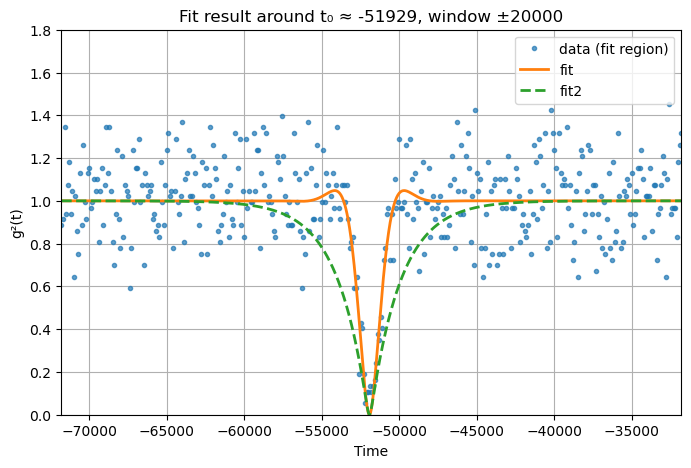

In [3]:
# --- Retrieve results from previous fit ---
popt = fit_result["popt"]
window_center = fit_result["window_center"]
window_half_width = fit_result["window_half_width"]
t_win = fit_result["t_win"]
g2_win = fit_result["g2_win"]

# --- Generate fit curve ---
t_fit = np.linspace(t_win.min(), t_win.max(), 2000)
g2_fit = g2_model(t_fit, *popt)
g2_fit_2 = g2_model(t_fit, popt[0],  popt[1],  popt[2]/5,  popt[3])

# --- Plot (zoomed to the fit window) ---
plt.figure(figsize=(8,5))
plt.plot(t_win, g2_win, "o", ms=3, alpha=0.7, label="data (fit region)")
plt.plot(t_fit, g2_fit, "-", lw=2, label="fit")
plt.plot(t_fit, g2_fit_2, "--", lw=2, label="fit2")
plt.xlabel("Time")
plt.ylabel("g²(t)")
plt.xlim(t_win.min(), t_win.max())
plt.ylim(0,1.8)
plt.legend()
plt.grid(True)
plt.title(f"Fit result around t₀ ≈ {popt[0]:.0f}, window ±{window_half_width:.0f}")
plt.show()